# Deep Learning-Based Groundwater Level prediction for the Virginia Eastern Shore

# Baseline Modeling (MLR)

### 1. Data Preparation & Model Training

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
wells = ["withams", "greenbush", "churchneck", "capecharles"]
data_path = Path("../data/processed")

### Separate target and independent variables

In [5]:
for w in wells:
    # 1. Load and prepare
    df = pd.read_csv(data_path/f"gw_{w}_ML_READY.csv")
    X = df.drop(columns=['date', 'gw_depth_ft'])
    y = df['gw_depth_ft']
    dates = pd.to_datetime(df['date'])

### Split (20% Test)

In [6]:
split_data = {}

for w in wells:
    df = pd.read_csv(data_path / f"gw_{w}_ML_READY.csv")

    X = df.drop(columns=["date", "gw_depth_ft"])
    y = df["gw_depth_ft"]
    dates = pd.to_datetime(df["date"])

    X_tr, X_te, y_tr, y_te, d_tr, d_te = train_test_split(
        X, y, dates, test_size=0.2, shuffle=False
    )

    split_data[w] = X_tr, X_te, y_tr, y_te, d_tr, d_te

### Scaling the Features

In [7]:
from sklearn.preprocessing import StandardScaler

scaled_data = {}

for w in wells:
    X_tr, X_te, y_tr, y_te, d_tr, d_te = split_data[w]

    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    scaled_data[w] = X_tr_s, X_te_s, y_tr, y_te, d_tr, d_te


### Train the MLR Model

In [12]:
from sklearn.linear_model import LinearRegression

models = {}

for w in wells:
    X_tr_s, _, y_tr, _, _, _ = scaled_data[w]

    model = LinearRegression()
    model.fit(X_tr_s, y_tr)

    models[w] = model
    


### Predict and Save results

In [9]:
results = {}

for w in wells:
    model = models[w]
    _, X_te_s, y_tr, y_te, d_tr, d_te = scaled_data[w]

    y_pred = model.predict(X_te_s)

    r2 = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))

    results[w] = {
        "y_train": y_tr,
        "y_test": y_te,
        "y_pred": y_pred,
        "dt_train": d_tr,
        "dt_test": d_te,
        "r2": r2,
        "rmse": rmse
    }

    print(f"{w.upper()} | R²={r2:.3f} | RMSE={rmse:.3f}")

WITHAMS | R²=0.997 | RMSE=0.039
GREENBUSH | R²=0.737 | RMSE=1.978
CHURCHNECK | R²=0.997 | RMSE=0.059
CAPECHARLES | R²=0.997 | RMSE=0.047


In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

data_path = Path("../data/processed")
model_path = Path("../models")
model_path.mkdir(parents=True, exist_ok=True)

for well in wells:
    df_raw = pd.read_csv(data_path / f"gw_{well}_ML_READY.csv")
    history = df_raw[['date', 'gw_depth_ft']].rename(columns={'date': 'Date', 'gw_depth_ft': 'Actual'})
    history.to_csv(model_path / f"HISTORY_{well}.csv", index=False)
    
    res = results[well]
    df_mlr = pd.DataFrame({
        'Date': np.array(res['dt_test']).flatten(), 
        'MLR_Pred': np.array(res['y_pred']).flatten()
    })
    df_mlr.to_csv(model_path / f"PRED_MLR_{well}.csv", index=False)

In [31]:
import joblib

# Run this in your notebook after training the MLR for each well
for w in wells:
    # Assuming 'model' is your trained sklearn LinearRegression object for that well
    joblib.dump(model, f"mlr_model_{w}.sav")

### Visualizing the result(Time Series Plot)

In [57]:
def plot_ts(y_tr, y_te, y_pred, d_tr, d_te, well):
    plt.figure(figsize=(14,5))

    plt.plot(d_tr, y_tr, label="Train (Actual)", color="blue", alpha=0.6)
    plt.plot(d_te, y_te, label="Test (Actual)", color="black")
    plt.plot(d_te, y_pred, label="Prediction", color="red", linestyle="--")

    plt.title(f"MLR Groundwater Depth – {well.upper()}")
    plt.xlabel("Date")
    plt.ylabel("Groundwater Depth (ft)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


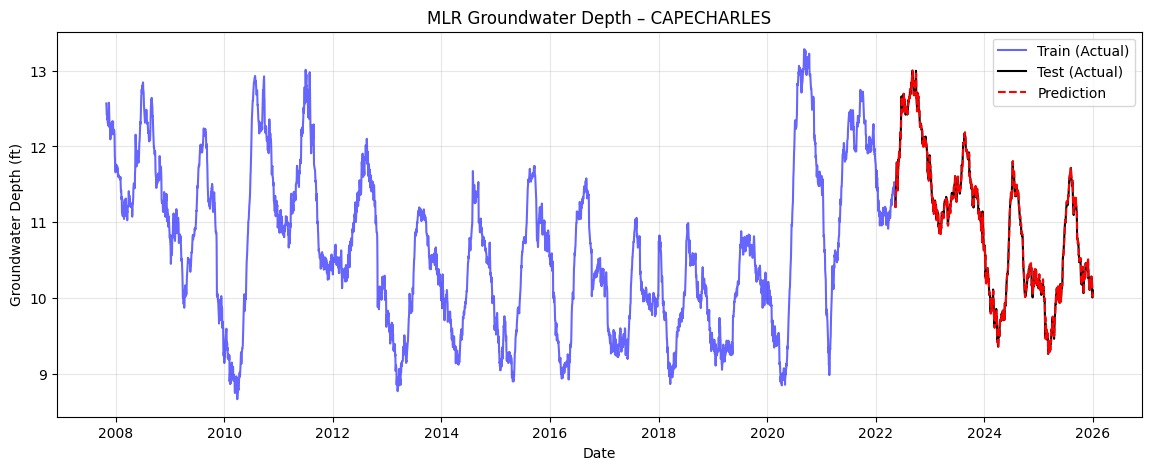

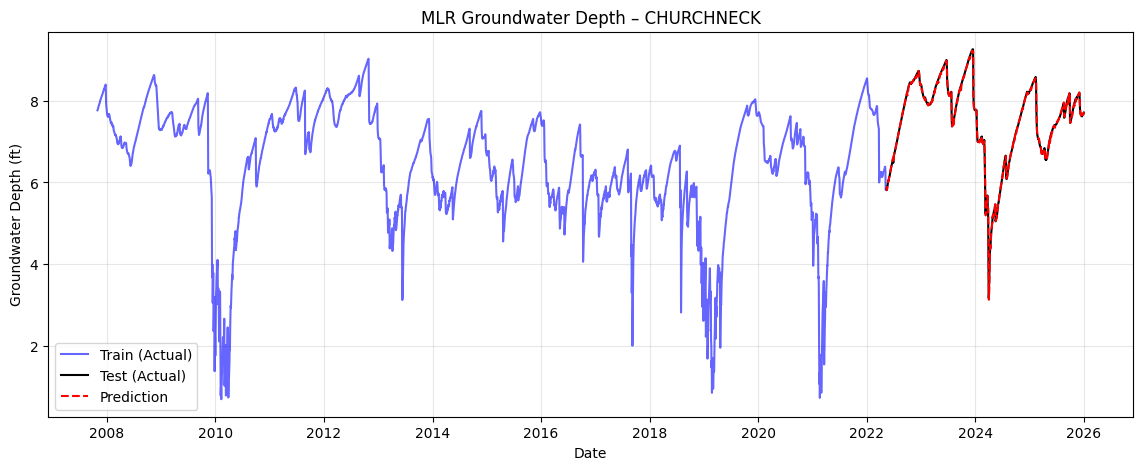

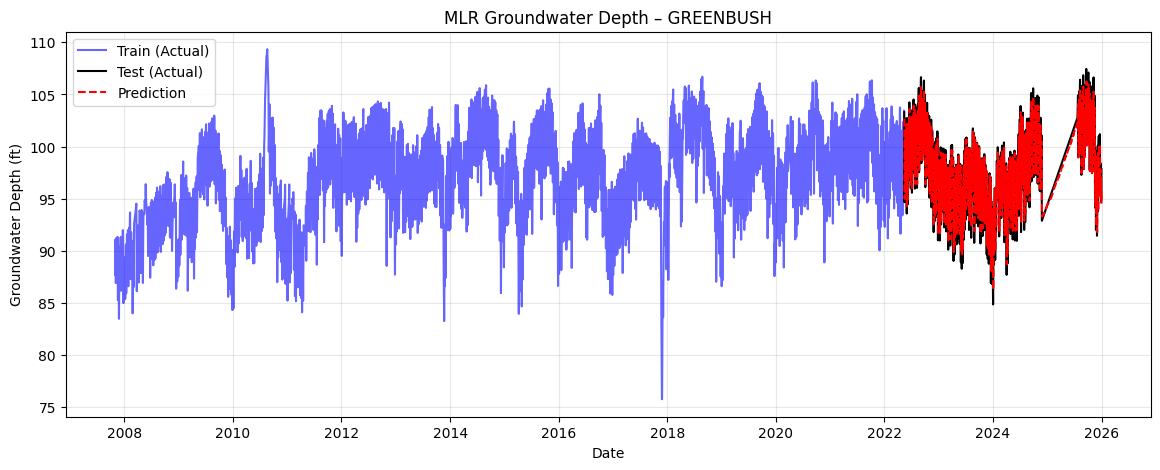

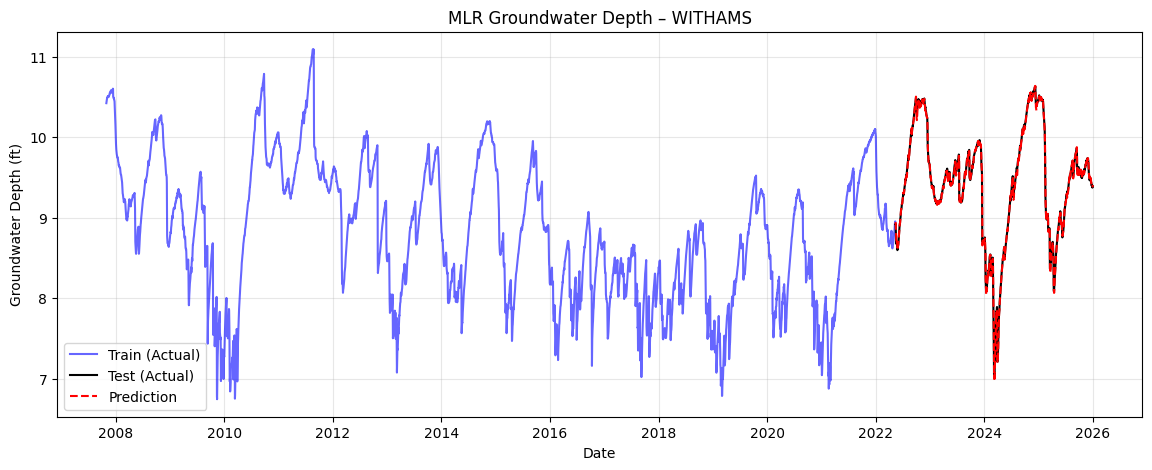

In [56]:
for w in wells:
    r = results[w]
    plot_ts(r["y_train"], r["y_test"], r["y_pred"],
            r["dt_train"], r["dt_test"], w)


# 2. Performance Metrics

### Display the Summary Table
The baseline Multiple Linear Regression output clearly indicates an extreme difference in aquifer behavior among the four sites. While Cape Charles, Churchneck, and Withams exhibited a very high degree of precision ($R^2 \approx 0.997$; $RMSE < 0.06$ ft), this was almost exclusively the result of the gw_lag1 feature that has captured the slow groundwater movement. 

A lower R^2 (0.737) and much higher RMSE (1.978 ft) at Greenbush indicates that nearly 2 feet of variation in water level at this location cannot be explained by the use of climate-related features and past water groundwater level alone. 

These differences suggest that Greenbush may be influenced by non-linear hydrogeologic processes or additional factors (e.g., localized pumping, differences in recharge characteristics). As such, it will require advanced machine learning techniques to accurately model the complexities in groundwater flow at Greenbush that the baseline linear modeling failed to capture.

In [59]:
baseline_df = pd.DataFrame({
    w: {
        "R2": results[w]["r2"],
        "RMSE": results[w]["rmse"]
    }
    for w in results
}).T
baseline_df

,R2,RMSE
capecharles,0.997306,0.046937
churchneck,0.996706,0.059431
greenbush,0.737293,1.977849
withams,0.996853,0.039444


### 50% Threshold
The blue dashed line represents a roughly 50% accuracy, but each of the four well sites are above that accuracy. 

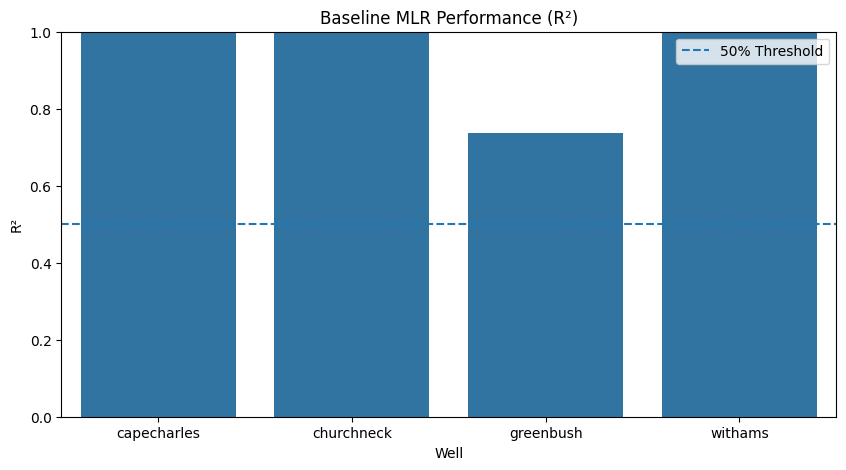

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))

sns.barplot(
    x=baseline_df.index,
    y=baseline_df["R2"]
)

plt.axhline(0.5, linestyle="--", label="50% Threshold")
plt.title("Baseline MLR Performance (R²)")
plt.ylabel("R²")
plt.xlabel("Well")
plt.ylim(0, 1)
plt.legend()
plt.show()



# 3. Model Diagnostics
Residual plots were developed to identify non-random trends or patterns that may indicate heteroscedasticity within a linear model (as well as possible violation of normal distribution assumptions). 

The diagnostic plots for Cape Charles, Churchneck, and Withams clearly show a nonrandom, funnel-shaped pattern in the residuals for each well, showing that there is clearly heteroscedasticity and that the linear model did not use as much of the information available from the input variables as it could have; even though R^2 was high. 

The heteroscedasticity is also very evident in the Greenbush residual plot as it shows a large spread and an arc shape to the data. This indicates that the linear assumptions were clearly wrong for this location. Also, the Q-Q plots for all four locations show a bowing and heavy-tailed behavior at the extreme end of the data.

Mathematically this shows that Linear Regression is incapable of modeling the non-Gaussian distribution of peak groundwater recharge events. Clearly, the baseline residual structure has failed for all four wells and therefore a shift to a CNN-LSTM architecture is needed because it can model non-linear threshold effects and complex temporal dependencies better than a Linear Regression model.

In [62]:
import scipy.stats as stats
def plot_diagnostics(y_test, y_pred, well):
    residuals = y_test - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

    # Residual plot
    ax1.scatter(y_pred, residuals, color='teal', alpha=0.5)
    ax1.axhline(0, color='red', linestyle='--')
    ax1.set_xlabel("Predicted Depth (ft)")
    ax1.set_ylabel("Residuals")
    ax1.set_title(f"{well.upper()} Residual Plot")
    ax1.grid(alpha=0.2)

    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('teal')
    ax2.get_lines()[0].set_alpha(0.4)
    ax2.set_title(f"{well.upper()} Normal Q-Q Plot")

    plt.tight_layout()
    plt.show()

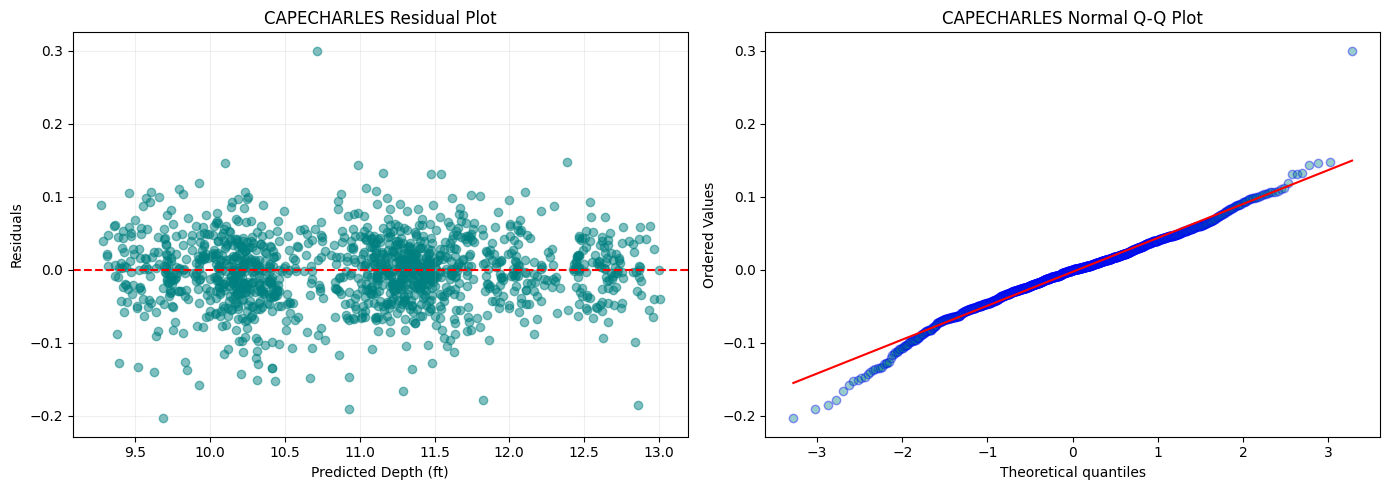

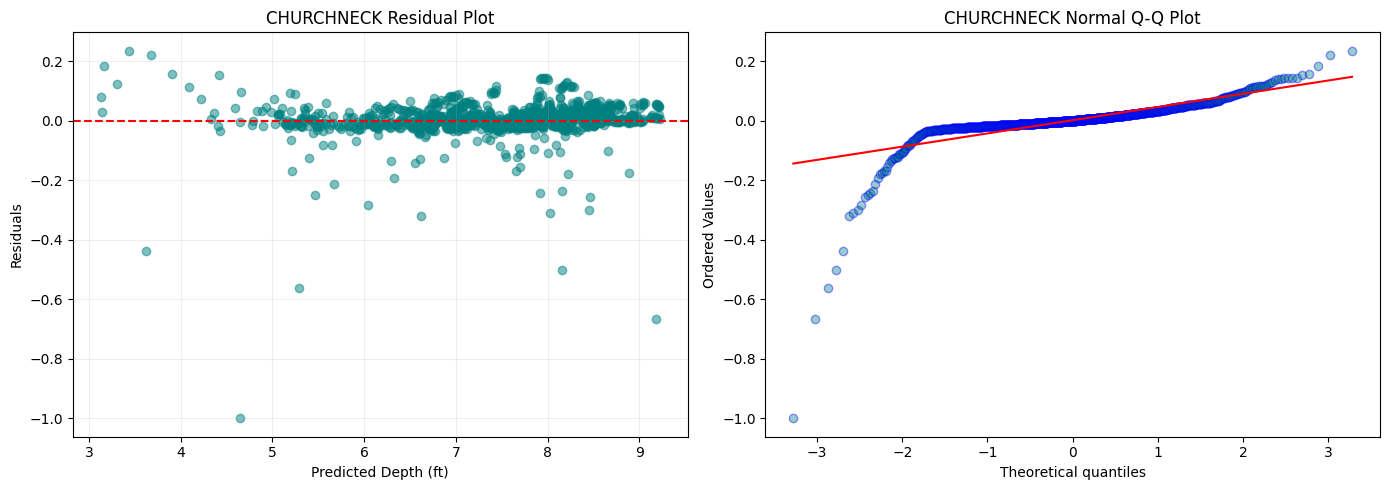

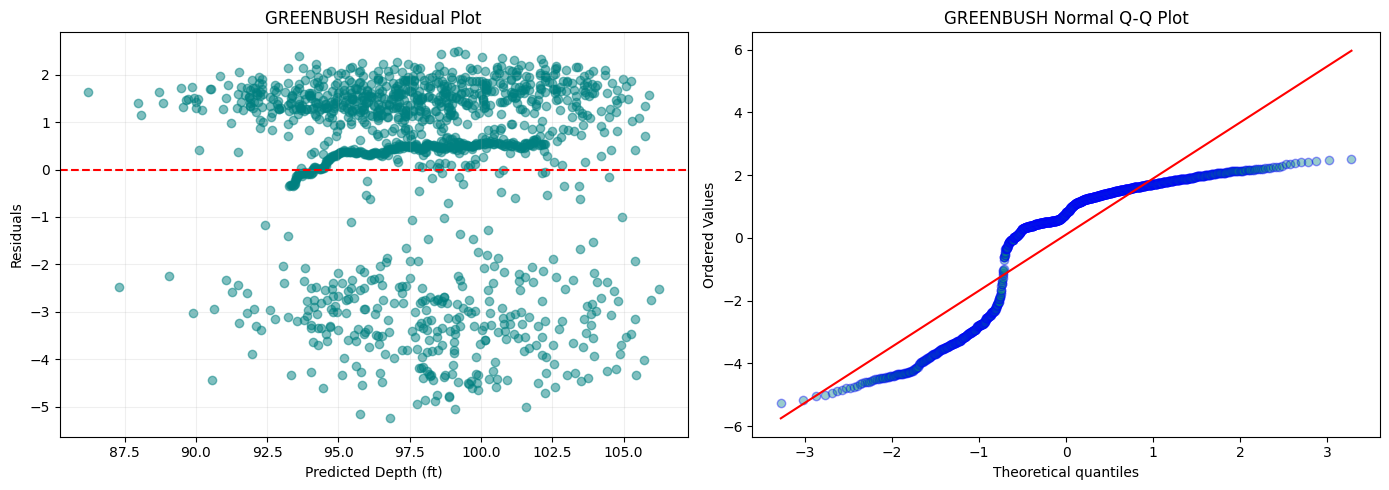

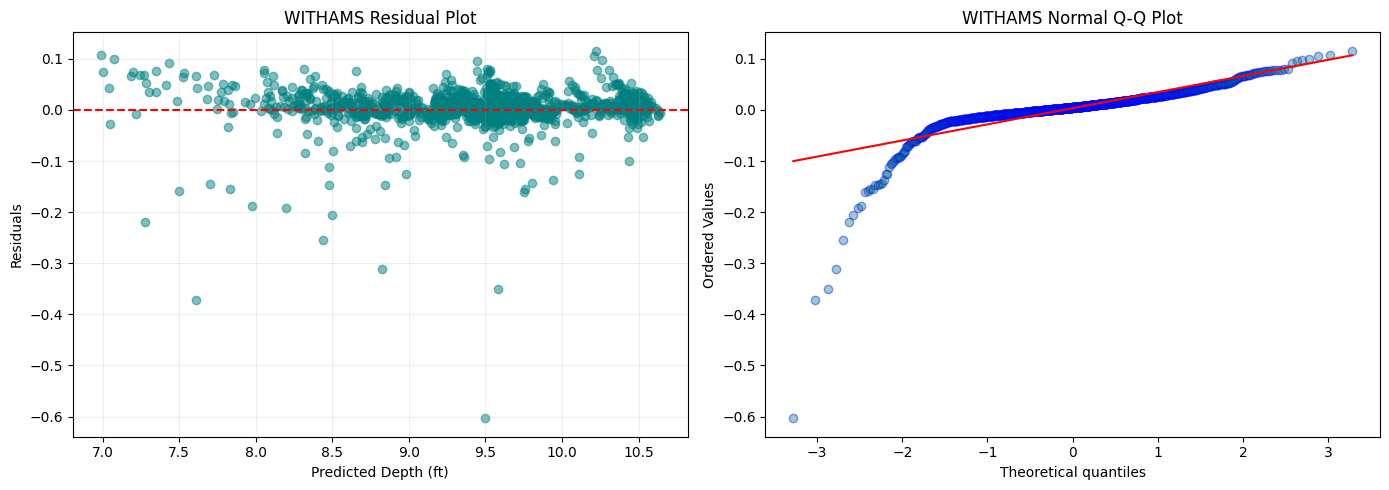

In [63]:
for w in wells:
    r = results[w]
    plot_diagnostics(r["y_test"], r["y_pred"], w)


# 4. conclusion
The main difference found within the baseline Multiple Linear Regression (MLR) analysis was an overall distinction between aquifer responses and modeled feasibility among the four study locations. 

Three of the locations (Cape Charles, Churchneck, and Withams) were highly precise as indicated by their high R squared values (R-squared = approximately 0.997); their Root Mean Square Error (RMSE) were also low (RMSE < 0.06 ft). However, this level of precision can be misleading since it is a result of the strong autocorrelation present in the gw_lag1 variable used in each location's model, masking the actual lack of ability for the MLR model to describe the underlying hydrogeologic processes.

Residuals from the MLR model exhibited evidence of heteroscedasticity and did not appear random; residuals from the three locations also showed evidence of bowing in the tails of the distribution in their Quantile-Quantile (Q-Q) plots, indicating that the MLR model could not adequately describe the large number of heavy-tailed distributions of peak recharge events.

The performance of the MLR model at the fourth location (Greenbush) provided additional support for this limitation; the R-squared value (R-squared = 0.737) for this location was significantly less than those obtained for the other three locations (R-squared = approximately 0.997); additionally, the RMSE for this location was also significantly larger (RMSE = 1.978 ft) than those for the other locations, resulting in nearly two feet of water level variability remaining unexplained by using the linear climate variables and historical lag variables alone. 

The above diagnostic failures provide mathematical evidence that the linear models developed in this study cannot identify the complex temporal lags, non-linear threshold effects and possible localized stresses (i.e., pumping) that exist in these groundwater systems. Therefore, a transition to a CNN-LSTM type of model is necessary to model the high-dimensionality, non-linearity and long-term temporal relationships in the data sets that the baseline linear model could not.